# 📚 Learning Vector Quantization (LVQ)

LVQ is a prototype-based supervised learning algorithm designed for classification.  

It maps input data to class labels by comparing feature vectors to a set of **prototypes**, one or more per class.

- Each prototype is a representative vector (like a centroid) in the feature space.
- Classification is done by assigning the label of the nearest prototype.
- Prototypes are adjusted during training to improve class separation.

LVQ is powerful for **interpretable segmentation tasks**, where having a codebook of representative profiles is more meaningful than having a black-box classifier. So it can be useful in **segmenting customers**, but also in **recommending products** based on their membership in a given segment.

🧠 You can think of it as a blend of k-NN and linear discriminants, but with learnable reference vectors.

<br>

<br>

We use [sklvq (Scikit-learning vector quantization)](https://sklvq.readthedocs.io/en/stable/), a scikit-learn compatible and expandable implementation of Learning Vector Quantization (LVQ) algorithms.

In [ ]:
!pip install sklvq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 1.9 MB/s eta 0:00:00


<br>

# 🏗️ Synthetic data generation: a simple customer segmentation example

We simulate a simple customer base for a hypotetical bank, generating 3 types of customers:

- **Mass**: younger workers with low assets
- **Mass-Affluent**: mid-aged or retired customers with moderate wealth
- **Affluent**: senior or high-income professionals with higher wealth

Features include:
- `Age`: normally distributed by group (i.e. Gaussian)
- `Profession`: categorical (Employee, Manager, Retired)
- `Assets`: scaled based on age and profession

This synthetic dataset provides a seemingly realistic structure for training and evaluating segmentation models.

<br>

Dataset overview:
Total samples: 999
Class distribution: [318 338 343]

Feature Statistics:
              Age  Profession         Assets  CustomerValue
count  999.000000  999.000000     999.000000     999.000000
mean    50.109017    0.836837  174037.527804       1.025025
std     20.067552    0.773046  140049.172336       0.813448
min     13.793663    0.000000  -26478.451896       0.000000
25%     32.447966    0.000000   53594.671791       0.000000
50%     44.598095    1.000000  143698.234902       1.000000
75%     71.003262    1.000000  246468.979773       2.000000
max     93.426674    2.000000  763224.128856       2.000000


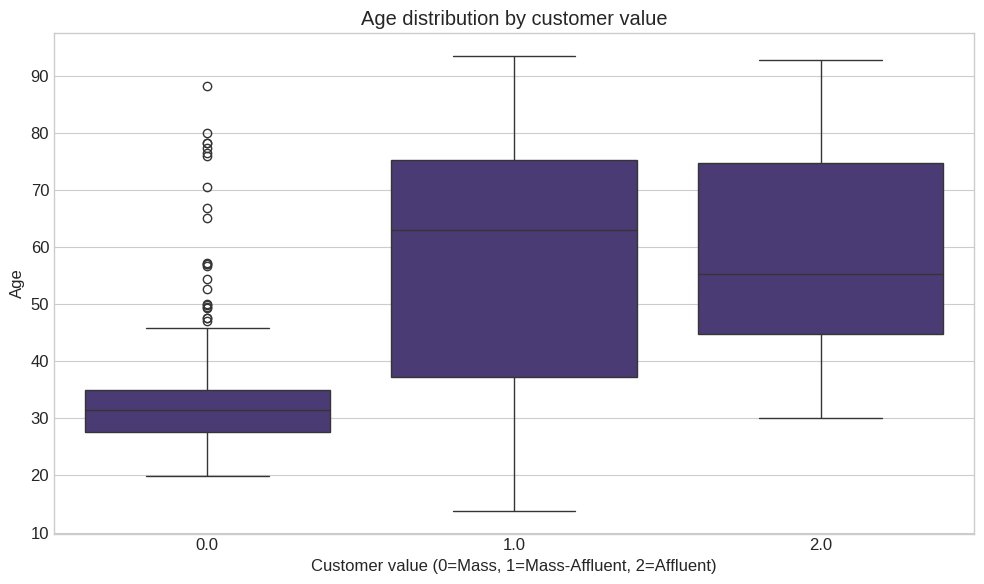

<Figure size 1000x600 with 0 Axes>

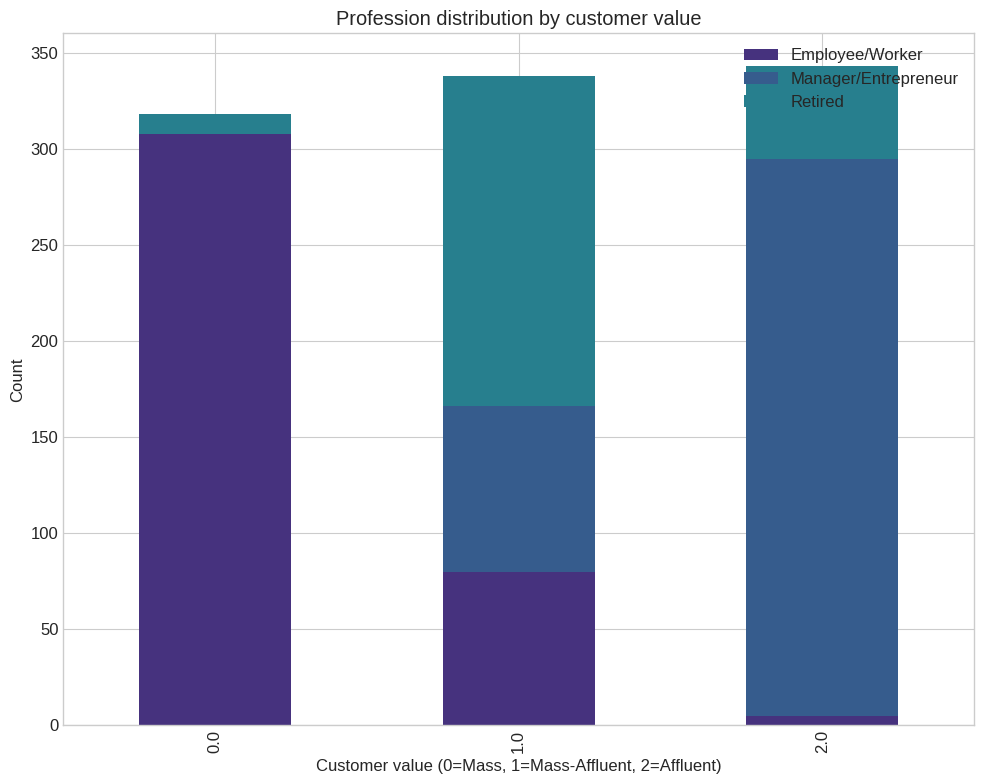

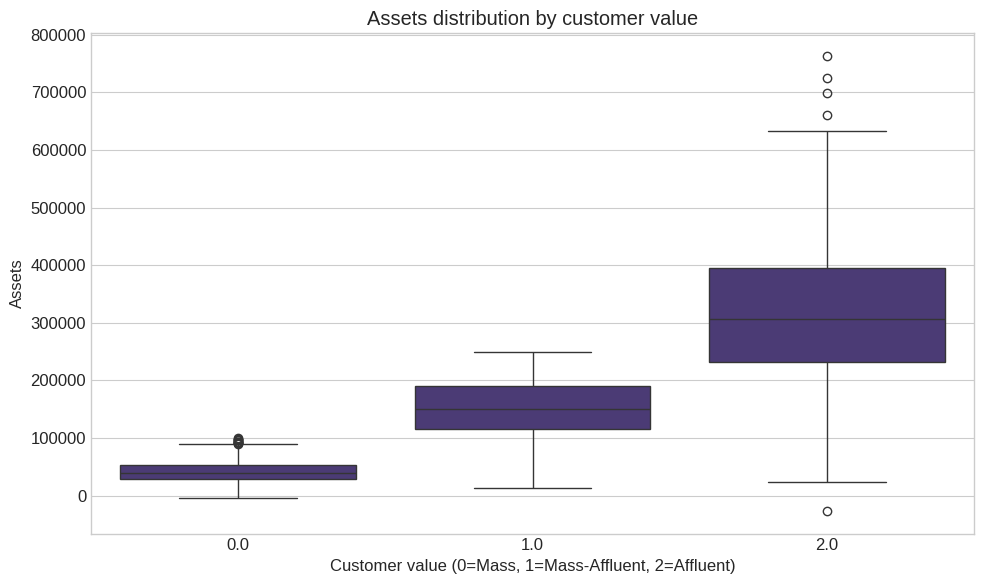

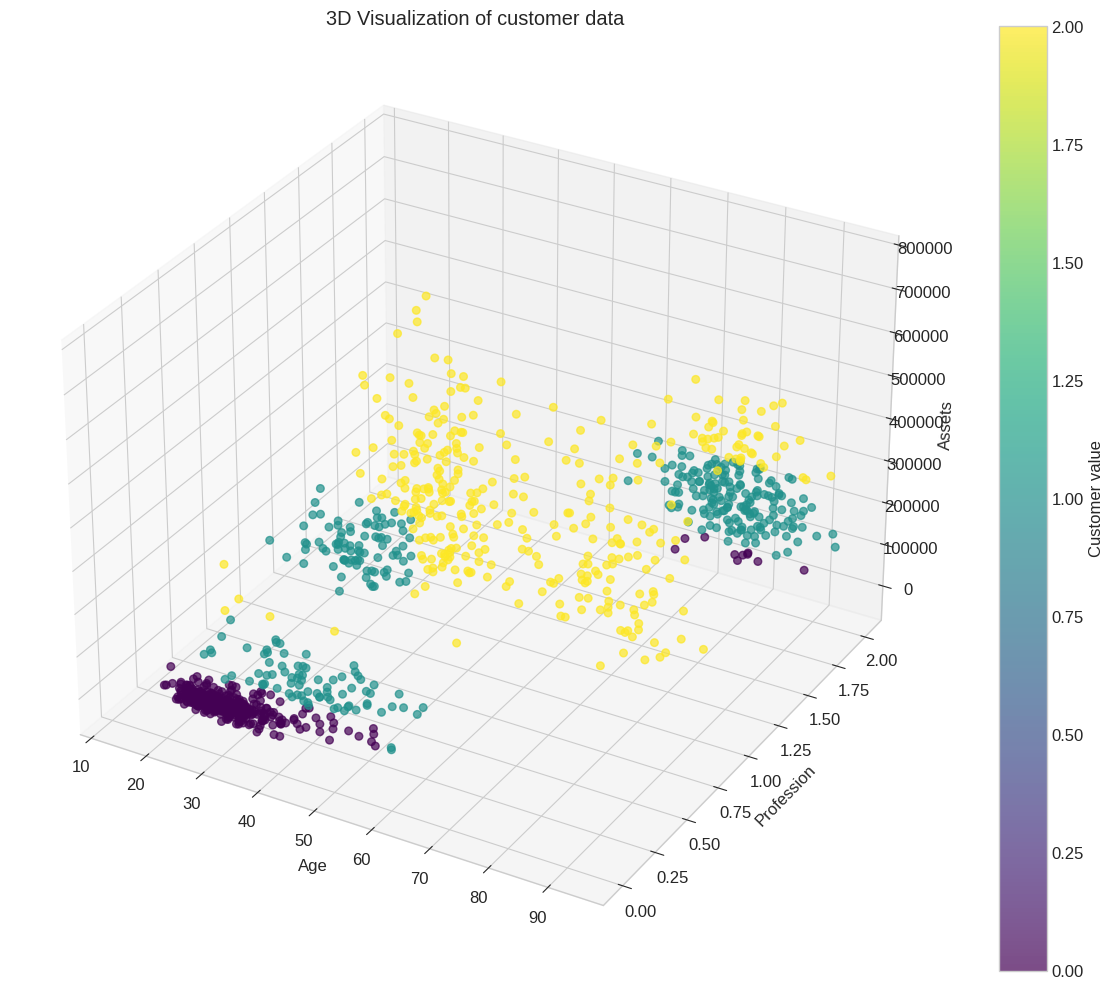

Data generation complete. Files saved for the next part.


In [ ]:
# Learning Vector Quantization (LVQ) Example - Part 1: Data Generation
# We create synthetic data assuming a banking customer segmentation scenario

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

def generate_customer_data(n_samples=1000):
    """
    Generate synthetic customer data for a bank.

    Parameters:
    - n_samples: Number of customers to generate

    Returns:
    - X: Features (age, profession, assets)
    - y: Customer class (0=low value, 1=medium value, 2=high value)
    """
    # Ensure we have a multiple of 3 for easier division
    n_per_group = n_samples // 3
    total_samples = n_per_group * 3

    # Generate age data
    age_young = np.random.normal(30, 5, n_per_group)
    age_middle = np.random.normal(45, 8, n_per_group)
    age_senior = np.random.normal(75, 7, n_per_group)

    # Generate profession data (0=employee/worker, 1=manager/entrepreneur, 2=retired)
    # Young people are mostly employees, middle-aged are mixed, seniors are mostly retired
    prof_young = np.random.choice([0, 1], size=n_per_group, p=[0.8, 0.2])
    prof_middle = np.random.choice([0, 1], size=n_per_group, p=[0.4, 0.6])
    prof_senior = np.random.choice([1, 2], size=n_per_group, p=[0.3, 0.7])

    # Generate assets data (correlated with age and profession)
    # Base assets increase with age
    assets_base_young = np.random.normal(40000, 15000, n_per_group)
    assets_base_middle = np.random.normal(130000, 40000, n_per_group)
    assets_base_senior = np.random.normal(150000, 60000, n_per_group)

    # Profession multiplier (employees have base assets, managers have more)
    prof_multiplier_young = np.where(prof_young == 0, 1, 3)
    prof_multiplier_middle = np.where(prof_middle == 0, 1, 2.5)
    prof_multiplier_senior = np.where(prof_senior == 1, 2, 1.2)

    # Calculate final assets with some noise
    assets_young = assets_base_young * prof_multiplier_young * np.random.normal(1, 0.2, n_per_group)
    assets_middle = assets_base_middle * prof_multiplier_middle * np.random.normal(1, 0.3, n_per_group)
    assets_senior = assets_base_senior * prof_multiplier_senior * np.random.normal(1, 0.25, n_per_group)

    # Combine data
    age = np.concatenate([age_young, age_middle, age_senior])
    profession = np.concatenate([prof_young, prof_middle, prof_senior])
    assets = np.concatenate([assets_young, assets_middle, assets_senior])

    # Create feature matrix
    X = np.column_stack([age, profession, assets])

    # Create target variable (customer value)
    # Low value: young employees with low assets or retired with low assets
    # Medium value: middle-aged employees or young managers or retired with medium assets
    # High value: middle-aged managers or seniors with high assets
    y = np.zeros(total_samples)

    for i in range(total_samples):
        if assets[i] > 250000 or (profession[i] == 1 and age[i] > 40):
            y[i] = 2  # Affluent
        elif assets[i] > 100000 or profession[i] == 1 or (age[i] > 60 and assets[i] > 50000):
            y[i] = 1  # Mass Affluent
        else:
            y[i] = 0  # Mass

    return X, y

# Generate the data
X, y = generate_customer_data(999)  # Using 999 to get exactly 333 samples per group

# Create a DataFrame for easier data exploration
df = pd.DataFrame(X, columns=['Age', 'Profession', 'Assets'])
df['CustomerValue'] = y

# Display basic statistics
print("Dataset overview:")
print(f"Total samples: {len(df)}")
print(f"Class distribution: {np.bincount(y.astype(int))}")
print("\nFeature Statistics:")
print(df.describe())

# Create separate figures for better visualization
# Figure 1: Age distribution by customer value
plt.figure(figsize=(10, 6))
sns.boxplot(x='CustomerValue', y='Age', data=df)
plt.title('Age distribution by customer value')
plt.xlabel('Customer value (0=Mass, 1=Mass-Affluent, 2=Affluent)')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

# Figure 2: Profession distribution by customer value
plt.figure(figsize=(10, 6))
prof_counts = df.groupby(['CustomerValue', 'Profession']).size().unstack()
prof_counts.plot(kind='bar', stacked=True)
plt.title('Profession distribution by customer value')
plt.xlabel('Customer value (0=Mass, 1=Mass-Affluent, 2=Affluent)')
plt.ylabel('Count')
plt.legend(['Employee/Worker', 'Manager/Entrepreneur', 'Retired'])
plt.tight_layout()
plt.show()

# Figure 3: Assets distribution by customer value
plt.figure(figsize=(10, 6))
sns.boxplot(x='CustomerValue', y='Assets', data=df)
plt.title('Assets distribution by customer value')
plt.xlabel('Customer value (0=Mass, 1=Mass-Affluent, 2=Affluent)')
plt.ylabel('Assets')
plt.tight_layout()
plt.show()

# Figure 4: 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Age'], df['Profession'], df['Assets'], c=df['CustomerValue'],
                     cmap='viridis', s=30, alpha=0.7)
ax.set_title('3D Visualization of customer data')
ax.set_xlabel('Age')
ax.set_ylabel('Profession')
ax.set_zlabel('Assets')
plt.colorbar(scatter, label='Customer value')
plt.tight_layout()
plt.show()

# Save the data for the next part
np.save('customer_data_X.npy', X)
np.save('customer_data_y.npy', y)

print("Data generation complete. Files saved for the next part.")


# ⚙️ Training an LVQ Model

We train a **Generalized Learning Vector Quantization (GLVQ)** model using the `sklvq` library.

Preprocessing steps:
- Standard scaling for numerical features (`Age`, `Assets`)
- One-hot encoding for the categorical feature (`Profession`)

Model setup:
- One prototype per class (you can use more, for example when you have a multimodal distribution in each class, i.e., two or more "typical situations")
- Optimization via steepest gradient descent

The result is a **codebook** of representative prototypes, each tied to one customer segment.


**How LVQ works:**
- You start by defining a small set of prototype vectors (codebooks), each representing a specific class or type of scenario.
- Each input data point (observation) is compared to the prototypes.
- The model assigns the observation to the nearest prototype (in feature space, typically using Euclidean distance).
- During training:
  - If an observation is correctly classified, the matching prototype is slightly moved closer to the data point.
  - If an observation is misclassified, the prototype is moved away from the data point.

> *Goal*:
  >  
  Over time, the prototypes adapt to best represent the structure of the data, forming natural "attraction zones" in the feature space.


In [ ]:
# Learning Vector Quantization (LVQ) Example - Part 2: Model Training

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklvq.models import GLVQ

# Load the data from part 1
X = np.load('customer_data_X.npy')
y = np.load('customer_data_y.npy')

# Create a DataFrame for easier preprocessing
df = pd.DataFrame(X, columns=['Age', 'Profession', 'Assets'])

# Separate numerical and categorical features
X_num = df[['Age', 'Assets']].values
X_cat = df[['Profession']].values.astype(int)

# Create a preprocessing pipeline
# We'll use StandardScaler for numerical features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [0, 2]),  # Age and Assets
        ('cat', OneHotEncoder(sparse_output=False), [1])  # Profession
    ],
    remainder='passthrough'
)

# Apply preprocessing
X_transformed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.3, random_state=42, stratify=y
)

# Train LVQ model - con 1 prototype for each class (they can be more)
lvq = GLVQ(
    prototype_init='class-conditional-mean',
    prototype_n_per_class=1,  # 1 prototype per class
    random_state=42,
    solver_type='steepest-gradient-descent',
    solver_params={'max_runs': 100}
)

# Train the model
lvq.fit(X_train, y_train)

# Make predictions
y_pred = lvq.predict(X_test)
y_pred_train = lvq.predict(X_train)

# Evaluate the model
print("\nModel Evaluation:")
print(f"Training accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Testing accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get the prototypes
prototypes = lvq.prototypes_

# Infer the labels for the prototypes
unique_classes = np.unique(y_train)
prototype_labels = unique_classes

# Interpret the prototypes
# First, we need to understand the structure of our transformed data
print("\nTransformed data structure:")
# If we used OneHotEncoder for Profession, we should have columns for each profession category
n_professions = len(np.unique(X_cat))
print(f"Number of profession categories: {n_professions}")

# Extract the prototype components
prototype_age = prototypes[:, 0]  # First column is Age (scaled)
prototype_assets = prototypes[:, 1]  # Second column is Assets (scaled)
prototype_professions = prototypes[:, 2:2+n_professions]  # Next columns are OneHot encoded professions

# Convert OneHot encoded professions back to categorical
prototype_profession_categories = np.argmax(prototype_professions, axis=1)

# Inverse transform the numerical features
# Create a dummy array with the same structure as the original data
dummy_data = np.zeros((len(prototypes), 2))  # Age and Assets
dummy_data[:, 0] = prototype_age
dummy_data[:, 1] = prototype_assets

# Get the original scaler for numerical features
num_scaler = preprocessor.named_transformers_['num']
prototype_num_original = num_scaler.inverse_transform(dummy_data)

# Create a DataFrame for the prototypes
prototype_df = pd.DataFrame()
prototype_df['Class'] = prototype_labels
prototype_df['Age'] = prototype_num_original[:, 0]
prototype_df['Profession'] = prototype_profession_categories
prototype_df['Assets'] = prototype_num_original[:, 1]

# Map profession categories to meaningful labels
profession_labels = {0: 'Employee/Worker', 1: 'Manager/Entrepreneur', 2: 'Retired'}
prototype_df['Profession_Label'] = prototype_df['Profession'].map(profession_labels)

print("\nPrototype Vectors (1 per class):")
print(prototype_df)

# Save the model results for the next part
np.save('lvq_prototypes.npy', prototypes)
np.save('lvq_prototype_labels.npy', prototype_labels)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('preprocessor.npy', preprocessor)

print("Model training complete. Files saved for the next part.")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Model Evaluation:
Training accuracy: 0.7940
Testing accuracy: 0.7533

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.95      0.84        95
         1.0       0.68      0.51      0.58       102
         2.0       0.80      0.82      0.81       103

    accuracy                           0.75       300
   macro avg       0.75      0.76      0.74       300
weighted avg       0.75      0.75      0.74       300


Transformed data structure:
Number of profession categories: 3

Prototype Vectors (1 per class):
   Class        Age  Profession         Assets      Profession_Label
0    0.0  30.160508           0    3614.097979       Employee/Worker
1    1.0  71.413286           2  122191.583413               Retired
2    2.0  59.485792           1  308321.458803  Manager/Entrepreneur
Model training complete. Files saved for the next part.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 📊 Visualizing Prototypes & Segments

We visualize the learned LVQ codebook in both 2D and 3D.

- **2D Plot**: Age vs. Assets, with prototypes marked as red stars
- **3D Plot**: Age, Profession, and Assets space

Prototypes serve as **interpretable summaries** of each class:
- They capture the "average" customer profile for each segment
- The nearest prototype defines the predicted class for each new observation

LVQ offers an elegant way to make segmentation both effective and explainable.
It works very well for getting marketing personas from situations set up as classification problems.


Prototype Vectors (Codebook):
   Class        Age  Profession         Assets      Profession_Label  \
0    0.0  30.150516           0    3528.736877       Employee/Worker   
1    1.0  71.423956           2  122165.614995               Retired   
2    2.0  59.490489           1  308388.718477  Manager/Entrepreneur   

  CustomerValue_Label  
0                Mass  
1       Mass-Affluent  
2            Affluent  


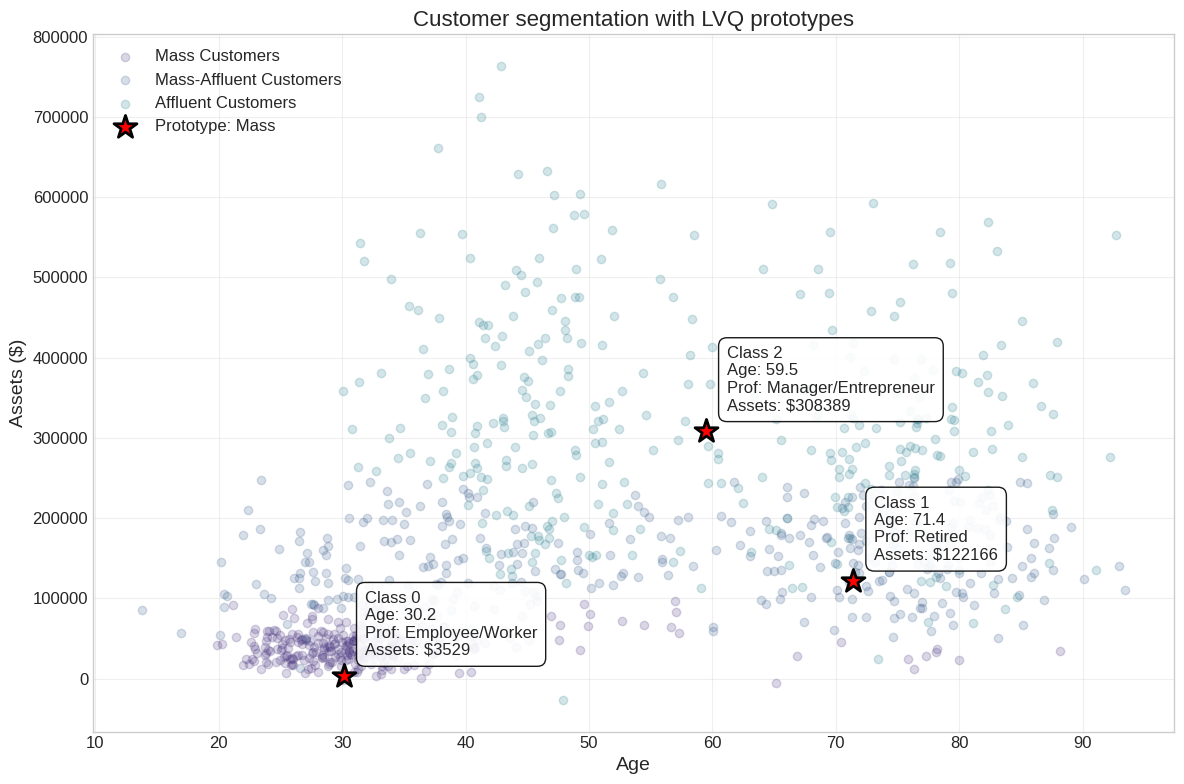

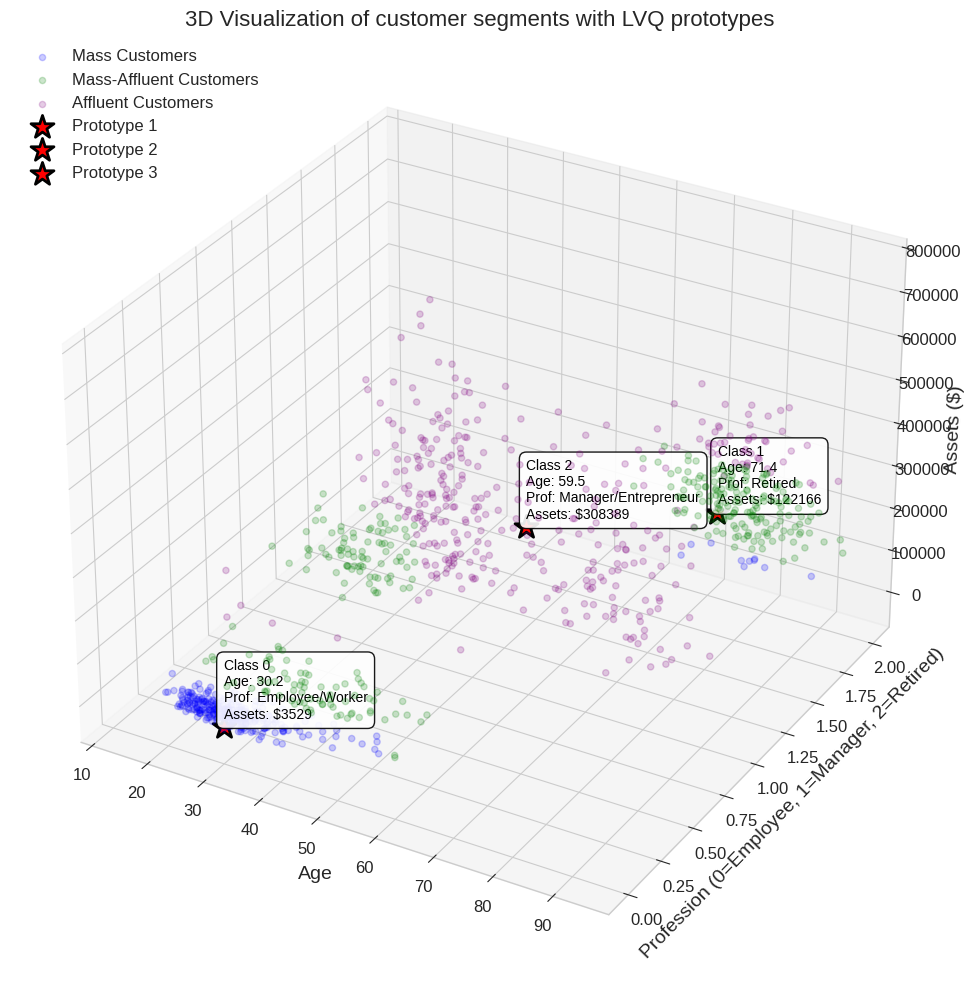


Prototype Summary:

Prototype for Mass Customers:
  Age: 30.2 years
  Profession: Employee/Worker
  Assets: $3528.74

Prototype for Mass-Affluent Customers:
  Age: 71.4 years
  Profession: Retired
  Assets: $122165.61

Prototype for Affluent Customers:
  Age: 59.5 years
  Profession: Manager/Entrepreneur
  Assets: $308388.72

LVQ Model Performance:
Test Accuracy: 0.7533


In [ ]:
# Learning Vector Quantization (LVQ) Example - Part 3: Visualization

from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

# Set plot style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

# Load the data and model results from previous parts
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
prototypes = np.load('lvq_prototypes.npy')
prototype_labels = np.load('lvq_prototype_labels.npy')

# Load original data for reference
X_original = np.load('customer_data_X.npy')
y_original = np.load('customer_data_y.npy')

# Create a DataFrame for the original data
df_original = pd.DataFrame(X_original, columns=['Age', 'Profession', 'Assets'])
df_original['CustomerValue'] = y_original

# Map profession categories to meaningful labels
profession_labels = {0: 'Employee/Worker', 1: 'Manager/Entrepreneur', 2: 'Retired'}
df_original['Profession_Label'] = df_original['Profession'].map(profession_labels)

# Map customer value to meaningful labels
customer_value_labels = {0: 'Mass', 1: 'Mass-Affluent', 2: 'Affluent'}
df_original['CustomerValue_Label'] = df_original['CustomerValue'].map(customer_value_labels)

# Create a DataFrame for the prototypes
# We need to extract the components correctly based on the preprocessing we did
# Assuming we have 3 profession categories (0, 1, 2)
n_professions = 3

# Extract the prototype components
prototype_age = prototypes[:, 0]  # First column is Age (scaled)
prototype_assets = prototypes[:, 1]  # Second column is Assets (scaled)
prototype_professions = prototypes[:, 2:2+n_professions]  # Next columns are OneHot encoded professions

# Convert OneHot encoded professions back to categorical
prototype_profession_categories = np.argmax(prototype_professions, axis=1)

# We need to inverse transform the numerical features
# This is a simplified approach - in a real scenario, you'd use the saved preprocessor
# Here we'll use the statistics from the original data
age_mean, age_std = df_original['Age'].mean(), df_original['Age'].std()
assets_mean, assets_std = df_original['Assets'].mean(), df_original['Assets'].std()

prototype_age_original = prototype_age * age_std + age_mean
prototype_assets_original = prototype_assets * assets_std + assets_mean

# Create a DataFrame for the prototypes
prototype_df = pd.DataFrame()
prototype_df['Class'] = prototype_labels
prototype_df['Age'] = prototype_age_original
prototype_df['Profession'] = prototype_profession_categories
prototype_df['Assets'] = prototype_assets_original
prototype_df['Profession_Label'] = prototype_df['Profession'].map(profession_labels)
prototype_df['CustomerValue_Label'] = prototype_df['Class'].map(customer_value_labels)

print("Prototype Vectors (Codebook):")
print(prototype_df)

# Visualization 1: Scatter plot of Age vs Assets with prototypes
plt.figure(figsize=(12, 8))

# Plot the original data points
for i, customer_type in enumerate(customer_value_labels.values()):
    mask = df_original['CustomerValue'] == i
    plt.scatter(
        df_original.loc[mask, 'Age'],
        df_original.loc[mask, 'Assets'],
        alpha=0.2,
        label=f'{customer_type} Customers'
    )

# Plot the prototypes with larger markers
for i, row in prototype_df.iterrows():
    plt.scatter(
        row['Age'],
        row['Assets'],
        s=300,
        marker='*',
        color='red',
        edgecolor='black',
        linewidth=2,
        label=f"Prototype: {row['CustomerValue_Label']}" if i == 0 else ""
    )

    # Add descriptive text labels for each prototype
    plt.annotate(
        f"Class {int(row['Class'])}\nAge: {row['Age']:.1f}\nProf: {row['Profession_Label']}\nAssets: ${row['Assets']:.0f}",
        (row['Age'], row['Assets']),
        xytext=(15, 15),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.9)
    )

plt.title('Customer segmentation with LVQ prototypes', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Assets ($)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lvq_prototypes_2d.png', dpi=300)
plt.show()

# Visualization 2: 3D scatter plot with prototypes
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
colors = ['blue', 'green', 'purple']
for i, customer_type in enumerate(customer_value_labels.values()):
    mask = df_original['CustomerValue'] == i
    ax.scatter(
        df_original.loc[mask, 'Age'],
        df_original.loc[mask, 'Profession'],
        df_original.loc[mask, 'Assets'],
        alpha=0.2,
        color=colors[i],
        label=f'{customer_type} Customers'
    )

# Plot the prototypes with larger markers
for i, row in prototype_df.iterrows():
    ax.scatter(
        row['Age'],
        row['Profession'],
        row['Assets'],
        s=300,
        marker='*',
        color='red',
        edgecolor='black',
        linewidth=2,
        label=f"Prototype {i+1}" if i == 0 else f"Prototype {i+1}"
    )

    # Add text labels for each prototype
    ax.text(
        row['Age'],
        row['Profession'],
        row['Assets'] + 20000,  # Offset to avoid overlap
        f"Class {int(row['Class'])}\nAge: {row['Age']:.1f}\nProf: {row['Profession_Label']}\nAssets: ${row['Assets']:.0f}",
        size=10,
        zorder=5,
        color='black',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.9, edgecolor='black')
    )

ax.set_title('3D Visualization of customer segments with LVQ prototypes', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Profession (0=Employee, 1=Manager, 2=Retired)', fontsize=14)
ax.set_zlabel('Assets ($)', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('lvq_prototypes_3d.png', dpi=300)
plt.show()


# Print a summary of the prototypes
print("\nPrototype Summary:")
for i, row in prototype_df.iterrows():
    print(f"\nPrototype for {row['CustomerValue_Label']} Customers:")
    print(f"  Age: {row['Age']:.1f} years")
    print(f"  Profession: {row['Profession_Label']}")
    print(f"  Assets: ${row['Assets']:.2f}")


def predict_with_prototypes(X, prototypes, prototype_labels):
    """Predict class labels based on nearest prototype."""
    # Calculate distances from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')

    # Find the index of the closest prototype for each point
    closest_prototype_idx = np.argmin(distances, axis=1)

    # Map to the corresponding class label
    predictions = prototype_labels[closest_prototype_idx]

    return predictions

# Calculate predictions and accuracy
y_pred = predict_with_prototypes(X_test, prototypes, prototype_labels)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nLVQ Model Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")



# 🔍 Final Remarks

We explored **Learning Vector Quantization (LVQ)** as a prototype-based method for interpretable customer segmentation.  
The model distilled the complexity of a multivariate dataset into a small number of representative vectors — the **codebook** — one per class.

- Each prototype captures the "center" of a customer class in terms of Age, Profession, and Assets.
- The final classification is performed by assigning each new observation to the closest prototype in feature space.

---

### Further exploration

- 🔁 **Multiple prototypes per class**  
  Try increasing the number of prototypes (e.g., 2 per class). This allows the model to capture intra-class variability (e.g., young affluent vs. senior affluent).

- 📏 **Distance Metrics**  
  LVQ relies on Euclidean distance. You might explore how the performance changes using different metrics (e.g., Mahalanobis) or by modifying feature scaling.



---

LVQ is a bridge between **machine learning** and **human understanding**: you don't just get predictions — you get examples that explain *why*.
